# Advanced PDF Retrieval & Optimization with LlamaIndex

This notebook builds on our previous exploration of embeddings and chunking to demonstrate advanced retrieval techniques using PDF documents. We'll explore query expansion, hybrid retrieval, and reranking to optimize the quality of search results.

## Section 1: Loading PDFs with PyMuPDF & LlamaIndex

### Why are we switching to PDFs?
- Most real-world document search tasks involve PDFs, not plain text
- Using PyMuPDF allows for better text extraction with preserved structure
- Working with PDFs introduces real-world challenges in document processing

### Installation

In [1]:
# Install required libraries
!pip install -q llama-index llama-index-llms-gemini pymupdf
!pip install -q llama-index-embeddings-huggingface
!pip install nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.4/144.4 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take

### Setting up the environment

In [2]:
import os
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import nest_asyncio

nest_asyncio.apply()

# Set up Google API key for Gemini
GOOGLE_API_KEY = "your key"  # Replace with your actual API key
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# Create a directory for our PDFs if it doesn't exist
!mkdir -p sample_docs

### Loading and Exploring PDF Documents

First, let's see how to load and extract text from a PDF using PyMuPDF:

In [5]:
from google.colab import files
import os

def upload_pdf():
    """Upload a PDF file and return its path."""
    print("Please select a PDF file to upload:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.pdf'):
            # Save to the sample_docs directory
            pdf_path = os.path.join("sample_docs", filename)

            # Create directory if it doesn't exist
            os.makedirs("sample_docs", exist_ok=True)

            # Save the file
            with open(pdf_path, 'wb') as f:
                f.write(uploaded[filename])

            print(f"PDF saved to {pdf_path}")
            return pdf_path
        else:
            print(f"File {filename} is not a PDF. Please upload a PDF file.")

    return None



Here you should upload a digital pdf (PDF where you can select some text). If you don't have a PDF, you can download this [sample pdf](https://drive.google.com/file/d/1jPMktO4uODm07z5smBPNGvTdxw868Kz8/view?usp=sharing) and then upload it.

In [4]:
# Uncomment to upload your own PDF
pdf_path = upload_pdf()

Please select a PDF file to upload:


Saving LenderFeesWorksheetNew (4).pdf to LenderFeesWorksheetNew (4).pdf
PDF saved to sample_docs/LenderFeesWorksheetNew (4).pdf


In [ ]:
#  Uncomment if you would like to add your own path
# pdf_path = "/content/sample_docs/sample_contract.pdf"

In [6]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file using PyMuPDF."""
    doc = fitz.open(pdf_path)

    # Extract text from all pages
    text = "\n".join([page.get_text() for page in doc])

    # Print some stats
    print(f"PDF: {pdf_path}")
    print(f"Number of pages: {len(doc)}")
    print(f"Extracted {len(text.split())} words from the PDF.")

    # Close the document
    doc.close()

    return text



In [7]:
# Example usage (after uploading a PDF):
if pdf_path:
    text = extract_text_from_pdf(pdf_path)
    print(text[:500])  # Print first 500 characte

PDF: sample_docs/LenderFeesWorksheetNew (4).pdf
Number of pages: 1
Extracted 404 words from the PDF.
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transac


### Integrating PyMuPDF with LlamaIndex

Now let's set up a custom loader to integrate PyMuPDF with LlamaIndex:

In [8]:
from llama_index.core import Document
from typing import List

def load_pdf_with_pymupdf(pdf_path: str) -> List[Document]:
    """Load a PDF and convert it to LlamaIndex Document format using PyMuPDF."""
    # Open the PDF
    doc = fitz.open(pdf_path)

    # Extract text from each page
    documents = []

    for i, page in enumerate(doc):
        text = page.get_text()

        # Skip empty pages
        if not text.strip():
            continue

        # Create Document object with metadata
        documents.append(
            Document(
                text=text,
                metadata={
                    "file_name": os.path.basename(pdf_path),
                    "page_number": i + 1,
                    "total_pages": len(doc)
                }
            )
        )

    # Close the document
    doc.close()

    # Print stats
    print(f"Processed {pdf_path}:")
    print(f"Extracted {len(documents)} pages with content")

    return documents



In [15]:
# Example usage:



from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, StorageContext, load_index_from_storage

def process_and_index_pdf(pdf_path):
    """Process a PDF and create both vector and keyword indices."""
    # Load documents
    documents = load_pdf_with_pymupdf(pdf_path)

    # Create vector index
    vector_index = VectorStoreIndex.from_documents(documents)

    print(f"Indexed {len(documents)} document chunks")

    return vector_index

index = process_and_index_pdf(pdf_path)
print("✅ PDF indexed successfully!")

pdf_docs = load_pdf_with_pymupdf(pdf_path)

Processed LenderFeesWorksheetNew (4) (1).pdf:
Extracted 1 pages with content


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Indexed 1 document chunks
✅ PDF indexed successfully!
Processed LenderFeesWorksheetNew (4) (1).pdf:
Extracted 1 pages with content


In [11]:
import os, glob
print("cwd:", os.getcwd())
print("Files here:")
!ls -la
print("\nPDFs in cwd:", glob.glob("*.pdf"))

cwd: /content
Files here:
total 28
drwxr-xr-x 1 root root 4096 Oct 28 09:24  .
drwxr-xr-x 1 root root 4096 Oct 28 09:13  ..
drwxr-xr-x 4 root root 4096 Oct 24 13:37  .config
-rw-r--r-- 1 root root 7625 Oct 28 09:24 'LenderFeesWorksheetNew (4).pdf'
drwxr-xr-x 1 root root 4096 Oct 24 13:37  sample_data
drwxr-xr-x 2 root root 4096 Oct 28 09:24  sample_docs

PDFs in cwd: ['LenderFeesWorksheetNew (4).pdf']


In [12]:
# Example: absolute path (Linux/macOS)
pdf_path = "/home/username/documents/my_real_file.pdf"

# or relative path (if file is in a subfolder called 'data')
pdf_path = "data/my_real_file.pdf"

In [13]:
# Colab only
from google.colab import files
uploaded = files.upload()  # choose the PDF in the file chooser
# uploaded is dict filename -> bytes; pick the first
pdf_path = list(uploaded.keys())[0]
print("Uploaded:", pdf_path)

# Continue with your PDF loading / indexing
pdf_docs = load_pdf_with_pymupdf(pdf_path)

Saving LenderFeesWorksheetNew (4).pdf to LenderFeesWorksheetNew (4) (1).pdf
Uploaded: LenderFeesWorksheetNew (4) (1).pdf
Processed LenderFeesWorksheetNew (4) (1).pdf:
Extracted 1 pages with content


In [14]:
import os, glob, sys

def find_or_prompt_pdf(preferred_name=None):
    # 1. If preferred_name provided and exists, return it
    if preferred_name and os.path.isfile(preferred_name):
        return preferred_name

    # 2. look for any PDFs in cwd
    pdfs = glob.glob("*.pdf")
    if pdfs:
        print("Found PDFs in cwd:", pdfs)
        return pdfs[0]  # pick the first (or change logic)

    # 3. try searching a bit deeper (one level)
    pdfs_nested = glob.glob("*/.pdf", recursive=True)
    if pdfs_nested:
        print("Found PDFs (recursive):", pdfs_nested[:10])
        return pdfs_nested[0]

    # 4. nothing found: show helpful diagnostics
    print("No PDF found in current directory or subdirectories.")
    print("cwd:", os.getcwd())
    print("Files in cwd:")
    !ls -la
    raise FileNotFoundError(
        "No PDF found. Place your PDF in the current working directory, "
        "set pdf_path to the correct absolute path, or upload the file "
        "if using Colab/Jupyter (see earlier code snippets)."
    )

# Usage
try:
    pdf_path = find_or_prompt_pdf(preferred_name="yourfile.pdf")
    print("Using PDF:", pdf_path)
    pdf_docs = load_pdf_with_pymupdf(pdf_path)   # your loader
except Exception as e:
    print("Error:", e)
    raise

Found PDFs in cwd: ['LenderFeesWorksheetNew (4) (1).pdf', 'LenderFeesWorksheetNew (4).pdf']
Using PDF: LenderFeesWorksheetNew (4) (1).pdf
Processed LenderFeesWorksheetNew (4) (1).pdf:
Extracted 1 pages with content


## Section 2: Indexing and Processing PDFs

Let's create the indexing infrastructure first:

In [18]:
import re
import sys
from google.ai import generativelanguage_v1beta as gl  # keep whatever you already import
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex # for semantic search
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

def clean_model_name(name: str) -> str:
    # replace common dash-like Unicode codepoints with ASCII hyphen
    dash_chars = r'[\u2010\u2011\u2012\u2013\u2014\u2015\u2212]'
    name = re.sub(dash_chars, '-', name)
    # remove ZERO WIDTH and other invisible characters (U+200B..U+200F, U+FEFF)
    name = re.sub(r'[\u200B-\u200F\uFEFF]', '', name)
    return name

def show_debug(name: str):
    print("repr:", repr(name))
    for i, ch in enumerate(name):
        print(f"{i:2d}: {ch!r} U+{ord(ch):04X}")

# Example: the string you copied that caused the error
raw = "models/gemini-2.5‐flash"   # <-- might contain a non-ASCII dash
clean = clean_model_name(raw)

print("Before cleaning:")
show_debug(raw)
print("\nAfter cleaning:")
show_debug(clean)

# Use the cleaned name (guarantees ASCII hyphens)
try:
    llm = Gemini(model=clean)
    Settings.llm = llm
    print("\nGemini LLM initialized successfully with model:", clean)
except Exception as e:
    # Print repr to reveal any remaining invisible / suspicious characters sent to API
    print("\nInitialization failed. Exception:")
    print(e)
    print("Model name sent (repr):", repr(clean))
    # Re-raise if you want the traceback
    raise

# Initialize embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.embed_model = embed_model

def process_and_index_pdf(pdf_path):
    """Process a PDF and create both vector and keyword indices."""
    # Load documents
    documents = load_pdf_with_pymupdf(pdf_path)

    # Create vector index
    vector_index = VectorStoreIndex.from_documents(documents)

    print(f"Indexed {len(documents)} document chunks")

    return vector_index

Before cleaning:
repr: 'models/gemini-2.5‐flash'
 0: 'm' U+006D
 1: 'o' U+006F
 2: 'd' U+0064
 3: 'e' U+0065
 4: 'l' U+006C
 5: 's' U+0073
 6: '/' U+002F
 7: 'g' U+0067
 8: 'e' U+0065
 9: 'm' U+006D
10: 'i' U+0069
11: 'n' U+006E
12: 'i' U+0069
13: '-' U+002D
14: '2' U+0032
15: '.' U+002E
16: '5' U+0035
17: '‐' U+2010
18: 'f' U+0066
19: 'l' U+006C
20: 'a' U+0061
21: 's' U+0073
22: 'h' U+0068

After cleaning:
repr: 'models/gemini-2.5-flash'
 0: 'm' U+006D
 1: 'o' U+006F
 2: 'd' U+0064
 3: 'e' U+0065
 4: 'l' U+006C
 5: 's' U+0073
 6: '/' U+002F
 7: 'g' U+0067
 8: 'e' U+0065
 9: 'm' U+006D
10: 'i' U+0069
11: 'n' U+006E
12: 'i' U+0069
13: '-' U+002D
14: '2' U+0032
15: '.' U+002E
16: '5' U+0035
17: '-' U+002D
18: 'f' U+0066
19: 'l' U+006C
20: 'a' U+0061
21: 's' U+0073
22: 'h' U+0068

Gemini LLM initialized successfully with model: models/gemini-2.5-flash


/tmp/ipython-input-3853278392.py:33: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model=clean)


## Section 2: Implement Query Expansion & Rewriting

Query expansion helps improve retrieval by adding relevant terms to the original query.

In [19]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-2.5-flash")
Settings.llm = llm

# Simple query expansion function using Gemini
def expand_query(query: str, num_expansions: int = 3) -> list:
    """Expand a query to include related terms using Gemini."""
    prompt = f"""
    I need to search a legal contract with this query: "{query}"

    Please help me expand this query by generating {num_expansions} alternative versions that:
    1. Use different but related terminology
    2. Include relevant legal terms that might appear in a contract
    3. Cover similar concepts but phrased differently

    Format your response as a list of alternative queries only, with no additional text.
    """

    response = llm.complete(prompt)

    # Extract the expanded queries
    expanded_queries = [line.strip() for line in response.text.split('\n') if line.strip()]

    # Add the original query if needed
    if query not in expanded_queries:
        expanded_queries = [query] + expanded_queries

    return expanded_queries

/tmp/ipython-input-1618107586.py:5: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.5-flash")


In [20]:
# Example usage:
expanded = expand_query("What are the penalties for late payments?")
for i, q in enumerate(expanded):
    print(f"{i+1}. {q}")

1. What are the penalties for late payments?
2. *   What are the remedies for non-payment or default on payment obligations, including any applicable interest or fees?
3. *   Does this contract specify any late fees, default interest, or liquidated damages for delinquent payments or failure to remit funds by the due date?
4. *   What are the contractual provisions regarding liabilities, charges, or other adverse actions for a breach of payment terms or failure to meet payment deadlines?


### Creating a Query Expansion Engine

Now let's implement a more structured query expansion using LlamaIndex's built-in functionality:

In [21]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever

# Function to create a query engine that uses query expansion
def create_query_expansion_engine(index):
    """Create a query engine that uses query expansion."""
    # First create multiple retrievers (base retriever)
    base_retriever = index.as_retriever(similarity_top_k=2)

    # Create a query fusion retriever
    fusion_retriever = QueryFusionRetriever(
        retrievers=[base_retriever],
        llm=llm,
        similarity_top_k=2,
        num_queries=3,  # Generate 3 queries per original query
        mode="reciprocal_rerank"  # Use reciprocal rank fusion
    )

    # Create the query engine with the fusion retriever
    query_engine = RetrieverQueryEngine.from_args(
        retriever=fusion_retriever,
        llm=llm,
        verbose=True
    )

    return query_engine


In [22]:
# Example usage:
expanded_query_engine = create_query_expansion_engine(index)
response = expanded_query_engine.query("What are the penalties for late payments?")
print(response)

The provided document does not contain information regarding penalties for late payments.


In [23]:
!pip install llama-index-retrievers-bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.3/683.3 kB 36.1 MB/s eta 0:00:00


## Section 3: Implement Hybrid Retrieval (Keyword + Vector Search)

Hybrid retrieval combines embedding-based semantic search with keyword-based retrieval for better results.

In [24]:
from llama_index.core import VectorStoreIndex
from llama_index.retrievers.bm25 import BM25Retriever

def create_hybrid_retriever(index, query, top_k=2):
    """Create a hybrid retrieval approach combining vector and keyword search."""
    # Method 1: Vector retrieval (semantic search)
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Method 2: BM25 retrieval (keyword-based search)
    # Get all nodes from the index
    nodes = [node for node in index.docstore.docs.values()]
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = bm25_retriever.retrieve(query)

    # Combine results (simple approach)
    all_nodes = []
    all_nodes.extend(vector_nodes)
    all_nodes.extend(keyword_nodes)

    # Remove duplicates
    unique_nodes = []
    seen_ids = set()
    for node in all_nodes:
        if node.node_id not in seen_ids:
            unique_nodes.append(node)
            seen_ids.add(node.node_id)

    # Sort by score (higher is better)
    sorted_nodes = sorted(unique_nodes, key=lambda x: x.score if hasattr(x, 'score') else 0.0, reverse=True)

    # Limit to top results
    top_nodes = sorted_nodes[:top_k]

    return top_nodes

In [25]:
# Example usage:
hybrid_nodes = create_hybrid_retriever(index, "What is the refund policy?")
for i, node in enumerate(hybrid_nodes):
    print(f"Result {i+1} (Score: {node.score:.4f}):")
    print(node.get_text())
    print("-" * 40)

DEBUG:bm25s:Building index from IDs objects


Result 1 (Score: 0.1672):
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard

### Comparing Retrieval Methods

Let's create a function to compare different retrieval methods:

In [26]:
def compare_retrieval_methods(index, query, top_k=2):
    """Compare different retrieval methods for the same query."""
    # Vector retrieval
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Keyword retrieval (BM25)
    nodes = [node for node in index.docstore.docs.values()]
    keyword_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = keyword_retriever.retrieve(query)

    # Hybrid retrieval
    hybrid_nodes = create_hybrid_retriever(index, query, top_k)

    # Create a comparison dataframe
    results = []

    for method, nodes in [
        ("Vector (Semantic)", vector_nodes),
        ("Keyword (BM25)", keyword_nodes),
        ("Hybrid", hybrid_nodes)
    ]:
        for i, node in enumerate(nodes):
            results.append({
                "Method": method,
                "Rank": i + 1,
                "Score": node.score if hasattr(node, 'score') else 0.0,
                "Content": node.get_text()[:200] + "...",  # First 200 chars
                "Page": node.metadata.get("page_number", "Unknown") if hasattr(node, 'metadata') else "Unknown"
            })

    results_df = pd.DataFrame(results)
    display(results_df)

    # Visualize scores
    plt.figure(figsize=(10, 6))
    for method in ["Vector (Semantic)", "Keyword (BM25)", "Hybrid"]:
        method_df = results_df[results_df["Method"] == method]
        plt.bar(
            [f"{method} - Rank {row['Rank']}" for _, row in method_df.iterrows()],
            method_df["Score"],
            alpha=0.7,
            label=method
        )

    plt.xlabel("Result")
    plt.ylabel("Retrieval Score")
    plt.title(f"Comparison of Retrieval Methods for Query: '{query}'")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

DEBUG:bm25s:Building index from IDs objects
DEBUG:bm25s:Building index from IDs objects


,Method,Rank,Score,Content,Page
0,Vector (Semantic),1,0.167223,"Your actual rate, payment, and cost could be h...",1
1,Keyword (BM25),1,0.000000,"Your actual rate, payment, and cost could be h...",1
2,Hybrid,1,0.167223,"Your actual rate, payment, and cost could be h...",1


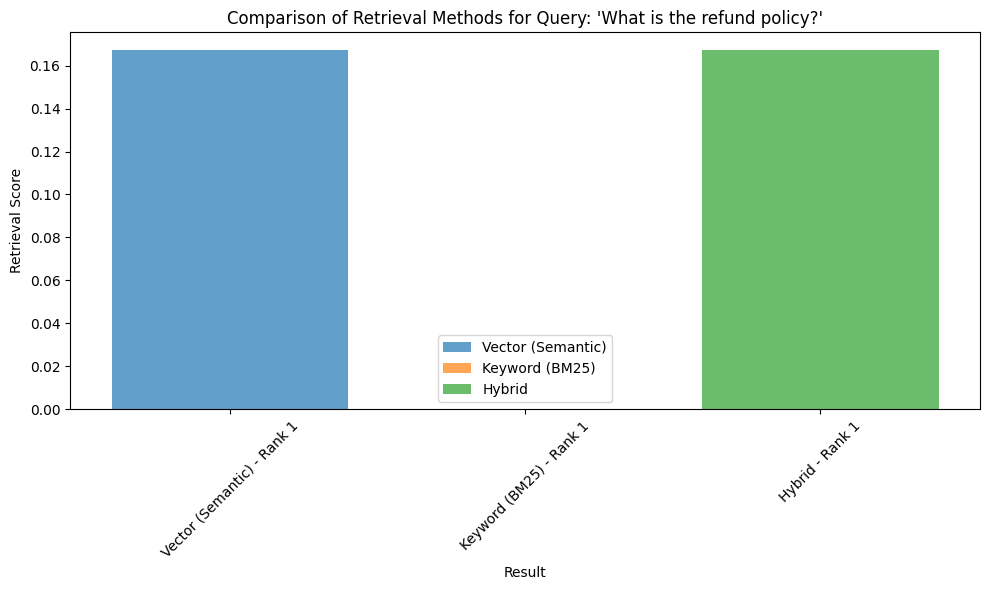

In [27]:
# Example usage:
comparison = compare_retrieval_methods(index, "What is the refund policy?")

## Section 4: Implement Reranking for More Accurate Results

Reranking helps prioritize the most relevant results after initial retrieval.

In [28]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.schema import NodeWithScore

# Create a reranker
def rerank_results(nodes, query, top_n=2):
    """Rerank retrieved nodes using the Sentence Transformer reranker."""
    # Create the reranker
    reranker = SentenceTransformerRerank(
        model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        top_n=top_n
    )

    # Rerank the nodes
    reranked_nodes = reranker.postprocess_nodes(
        nodes,
        query_str=query
    )

    return reranked_nodes

# Function to demonstrate the reranking process
def demonstrate_reranking(index, query, top_k=4):
    """Demonstrate the reranking process on retrieval results."""
    # First retrieve more nodes than we need
    retriever = index.as_retriever(similarity_top_k=top_k)
    nodes = retriever.retrieve(query)

    print(f"Query: {query}")
    print("\nOriginal Retrieval Order:")
    for i, node in enumerate(nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Now rerank them
    reranked_nodes = rerank_results(nodes, query, top_n=2)

    print("\nAfter Reranking:")
    for i, node in enumerate(reranked_nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Create comparison dataframe
    results = []

    # Original ranking
    for i, node in enumerate(nodes):
        results.append({
            "Stage": "Original Retrieval",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    # Reranked
    for i, node in enumerate(reranked_nodes):
        results.append({
            "Stage": "After Reranking",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    results_df = pd.DataFrame(results)
    display(results_df)

    return results_df

# Example usage:
reranking_demo = demonstrate_reranking(index, "What happens if I cancel the service?", top_k=4)

Query: What happens if I cancel the service?

Original Retrieval Order:
1. (Score: 0.0432) - Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


After Reranking:
1. (Score: -11.1824) - Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a...


,Stage,Rank,Score,Content,Page
0,Original Retrieval,1,-11.182405,"Your actual rate, payment, and cost could be h...",1
1,After Reranking,1,-11.182405,"Your actual rate, payment, and cost could be h...",1


## Complete End-to-End Example - Building an Advanced RAG Pipeline

Now let's combine all these techniques into an advanced RAG pipeline:

In [32]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    node_postprocessors = []
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-6-v2",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors.append(reranker)


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=node_postprocessors
    )

    return query_engine

In [33]:
# Example usage:
#pdf_path = upload_pdf()
index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)
response = rag_engine.query("What are the penalties for late payments?")
print('\nFinal Response:\n ---------------------- \n')
print(response)

Processed LenderFeesWorksheetNew (4) (1).pdf:
Extracted 1 pages with content


DEBUG:bm25s:Building index from IDs objects


Indexed 1 document chunks
Index contains 1 nodes, using top_k=1

Final Response:
 ---------------------- 

This document does not contain information regarding penalties for late payments.


### Why This Approach Works Well

1. **Hybrid Retrieval**: By combining vector search (semantic understanding) with BM25 (keyword matching), we get the best of both worlds:
   - Vector search finds semantically related content even if keywords don't match
   - BM25 ensures we don't miss exact term matches that might be relevant

2. **Reranking**: The SentenceTransformer reranker provides a second opinion on relevance:
   - It uses a specialized cross-encoder model to score query-chunk pairs
   - This helps filter out chunks that might be tangentially related but not directly relevant
   - Results in higher precision answers with less noise

3. **Simplicity**: This approach avoids complex routing logic while still delivering high-quality results:
   - No need for multiple specialized retrievers with complex selection logic
   - Handles most query types well without additional complexity
   - Easier to maintain and understand

This pipeline will retrieve relevant information from PDFs and generate concise, accurate responses using Gemini's capabilities.

## Conclusion

In this notebook, we explored advanced PDF retrieval techniques with LlamaIndex:

1. Loading and processing PDFs using PyMuPDF
2. Implementing query expansion to improve retrieval quality
3. Using hybrid retrieval to combine semantic and keyword search
4. Applying reranking to prioritize the most relevant results
5. Building an advanced RAG pipeline that combines all these techniques

These techniques can significantly improve the quality of information retrieval from PDFs and other document types in real-world applications.